# Model training for NFL play prediction

---
 
In this notebook, we train multiple regression and ANN models to predict the yards gained per football play. As a basis we use the preselected data created by the `preprocessing.py``.

### Inline preprocessing steps:

---

As we use 5-fold cross-validation to protect the model against overfitting, we need a dynamic preprocessing appraoch. Therefore a pipeline provided by the `preprocessing.py`` will be used to process the training data of each fold. Further we use a nested cross validation to ensure the quality of our model using selected hyperparameters.


### Contributors

All contributors are only assigned to their primary task, the teams still interchanged know-how and worked on one anothers approaches.

---

##### Preprocessing Team

- Tim Oliver Krause (1689074)
- Jan Thilo Viktorin (1684159)
- Joël Pflomm (1634591)

##### Model Team

- Franziska Köllschen (1981780)
- Steffen Hüls (1979863)
- Matthias Biermanns (1980701)

## Coding

### Coding Foundations

In [1]:
# basic imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.base import TransformerMixin, BaseEstimator
import preprocessing

# import for data visualization
import matplotlib.pyplot as plt

# imports for regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import ParameterGrid

import xgboost as xgb

from subprocess import call
from sklearn.tree import export_graphviz
from IPython.display import Image

In [2]:
# static variables
FILE_LIST = [f'./Data/play_by_play_{year}.csv' for year in range(1999, 2024)]
PREPROCESSOR = preprocessing.NFLPreprocessing(FILE_LIST)
TARGET_NAME = 'yards_gained'
RANDOM_STATE = 42
LABEL_PASS = 'Pass'
LABEL_RUN = 'Run'

# global variables
model_counter = 0
plot_counter = 0

2023-12-03 20:10:53.163 | INFO     | preprocessing:__init__:58 - --- Executing Preprocessing Steps ---
2023-12-03 20:10:53.170 | INFO     | preprocessing:make_combined_df:146 - Loading csv files
/Users/I538906/Documents/GitHub/NFL_play_prediction/preprocessing.py:151: DtypeWarning: Columns (36,37,179,180,189,190,197,198,203,204,205,206,213,214,218,219,220,222,224,226,248,249,253,254,255,260,262,263,266,267,268,269,283,284) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
/Users/I538906/Documents/GitHub/NFL_play_prediction/preprocessing.py:151: DtypeWarning: Columns (37,45,179,180,182,183,189,190,193,194,197,198,203,204,205,206,218,219,220,248,249,253,254,255,260,262,263,283,284) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
/Users/I538906/Documents/GitHub/NFL_play_prediction/preprocessing.py:151: DtypeWarning: Columns (37,179,180,182,183,189,190,193,194,197,198,203,204,205,206

##### General functions

In [3]:
def get_sample(df, data_fraction):
    # set fraction between 0 and 1 (e.g. 0.05 -> 5% df)
    df_sampled = df.sample(frac=data_fraction, random_state=RANDOM_STATE)

    # Reset the index if needed
    df_sampled = df_sampled.reset_index(drop=True)

    return df_sampled

def split_feature_target(df):
    features = df.drop(TARGET_NAME, axis=1)
    target = df[TARGET_NAME]

    return features, target

def plot_predicts(y_test, predictions, label):
    # Evaluate the models
    pass_mse = mean_squared_error(y_test, predictions)
    pass_rmse = mean_squared_error(y_test, predictions, squared = False)
    pass_msa = mean_absolute_error(y_test, predictions)

    # Visualize predictions for passes
    plt.scatter(y_test, predictions)
    plt.title(label + ' Model: True vs Predicted Yards')
    plt.xlabel('True Yards')
    plt.ylabel('Predicted Yards')
    plt.show()

    print(f"Mean Squared Error: {pass_mse}")
    print(f"Mean Absolute Error: {pass_msa}")
    print(f"Root Mean Squared Error: {pass_rmse}")

def plot_decision_tree(pipeline, label, target_tree=0):
    global plot_counter
    fileName = f'./results/plot_{plot_counter}_{label}_rf'
    # Export the decision tree as a dot file
    export_graphviz(pipeline.named_steps['regressor'].estimators_[target_tree], out_file=f'{fileName}.dot', 
                    feature_names=PREPROCESSOR.get_prepro_feature_names_from_pipeline(),
                    rounded=True, proportion=False, 
                    precision=2, filled=True)

    # Convert the dot file to png using Graphviz (make sure Graphviz is installed)
    call(['dot', '-Tpng', f'{fileName}.dot', '-o', f'{fileName}.png', '-Gdpi=600'])

    plot_counter = plot_counter + 1

    display(Image(filename=f'{fileName}.png'))

def plot_decision_tree_xgb(pipeline, label, target_tree=0):
    global plot_counter
    fileName = f'./results/plot_{plot_counter}_{label}_xgb'

    xgb.plot_tree(pipeline.named_steps['regressor'], num_trees=target_tree)
    fig = plt.gcf()
    fig.set_size_inches(15, 10)
    fig.canvas.manager.set_window_title('Decision Tree for ' + label + ' Model')
    fig.savefig(f'{fileName}.png')
    
    plot_counter = plot_counter + 1

    Image(filename=f'{fileName}.png')

def plot_train_val_loss(training_losses, validation_losses, label):
    global plot_counter
    fileName = f'./results/plot_{plot_counter}_{label}_ann'
    # Plot the training and validation loss
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Neural Network Training and Validation Loss - ' + label)
    plt.legend()
    plt.savefig(f'{fileName}.png')
    plt.show()
    plot_counter = plot_counter + 1

def plot_feature_importances(pipeline, label, show_top_n=10):
    # Get feature importances
    feature_importances = pipeline.named_steps['regressor'].feature_importances_

    # Get the feature names after preprocessing
    columns = PREPROCESSOR.get_prepro_feature_names_from_pipeline()

    # Create a DataFrame to display feature importances
    feature_importance_df = pd.DataFrame({'Feature': columns, 'Importance': feature_importances})

    # Sort the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'][:show_top_n], feature_importance_df['Importance'][:show_top_n])
    plt.xlabel('Importance')
    plt.title(f'Top {show_top_n} Feature Importances - {label}')
    plt.show()

def plot_coef(pipeline):
    coefs = pipeline.named_steps['regressor'].coef_

    # Get the feature names after preprocessing
    columns = PREPROCESSOR.get_prepro_feature_names_from_pipeline()

    coef = pd.DataFrame(coefs, columns=["Coefficients"], index=columns)
    coef.plot(kind="barh", figsize=(9, 7))
    plt.show()

##### Functions for cross validation

In [4]:
def test_model(pipeline, df, data_fraction: float = None, label = None):
    data = df.copy()
    if(data_fraction and data_fraction < 1.0):
        data = get_sample(data, data_fraction)
    
    features, target = split_feature_target(data)
    X_train, X_test, y_train, y_test = train_test_split(features, target)

    pipeline.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = pipeline.predict(X_test)

    plot_predicts(y_test, predictions, label if label else '')
    save_model(features, target, predictions, label, title_appendix=f'normal_{data_fraction*100}%_of_data')

    return y_test, predictions

def test_model_k_fold(df, pipeline, label, k_folds: int=3, data_fraction: float = 1.0):
    data = df.copy()
    if(data_fraction and data_fraction < 1.0):
        data = get_sample(df, data_fraction)
    
    features, target = split_feature_target(data)

    cv_predictions = cross_val_predict(pipeline, features, target, cv=k_folds)
    
    plot_predicts(target, cv_predictions, label)
    save_model(features, target, cv_predictions, label, title_appendix=f'{k_folds}_folds_{data_fraction*100}%_of_data')
    return cv_predictions

def estimate_hyperparams(df, pipeline, scoring, label, k_folds=3, parameters={}, data_fraction: float = 1.0):
    global model_counter
    data = df.copy()
    if(data_fraction and data_fraction < 1.0):
        data = get_sample(df, data_fraction)

    features, target = split_feature_target(data)
    
    # create the grid search instance
    grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=scoring, cv=k_folds, return_train_score=False, n_jobs=1)

    # run the grid search
    grid_search_estimator.fit(features, target)
    
    cv_results_df = pd.DataFrame(grid_search_estimator.cv_results_)
    cv_results_df.to_excel(f'./results/model_{model_counter}_{label}_nestedCV_{data_fraction*100}%_of_data.xlsx')
    display(grid_search_estimator.best_params_)
    display(cv_results_df)

    return grid_search_estimator

def generate_param_combinations(parameters):
    '''list of list required for cross product of two lists'''
    return list(ParameterGrid(parameters))

def save_model(features, target, predictions, label, title_appendix: str = ''):
    global model_counter

    predictions_df = pd.DataFrame({'predicted yards_gained': predictions})
    save_model = pd.concat([features, target, predictions_df], axis=1)

    if (title_appendix != ''):
        title_appendix = '_'+title_appendix
    save_model.to_excel(f'./results/model_{model_counter}_{label}{title_appendix}.xlsx')

    # increase counter for files
    model_counter = model_counter + 1
    pass

##### MLP Regressor Class - with history

In [ ]:
class MLPWithHistory(BaseEstimator, TransformerMixin):
    def __init__(self, mlp_params=None):
        self.mlp_params = mlp_params
        self.training_losses = []
        self.validation_losses = []
        self.mlp_regressor = MLPRegressor(**(self.mlp_params or {}))

    def fit(self, X, y):
        X, X_val, y, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

        for epoch in range(self.mlp_regressor.max_iter):
            self.mlp_regressor.partial_fit(X, y)

            # Calculate training loss
            y_train_pred = self.mlp_regressor.predict(X)
            training_loss = mean_squared_error(y, y_train_pred)
            self.training_losses.append(training_loss)

            # Calculate validation loss
            y_val_pred = self.mlp_regressor.predict(X_val)
            validation_loss = mean_squared_error(y_val, y_val_pred)
            self.validation_losses.append(validation_loss)

        return self

    def transform(self, X):
        return X

    def predict(self, X):
        return self.mlp_regressor.predict(X)

    def get_params(self, deep=True):
        return {"mlp_params": self.mlp_params}

    def set_params(self, **params):
        self.mlp_params = params["mlp_params"]
        self.mlp_regressor.set_params(**self.mlp_params)
        return self
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return -mean_squared_error(y, y_pred)

##### Train and Test Data

In [5]:
run_df = PREPROCESSOR.run_df
pass_df = PREPROCESSOR.pass_df

run_features, run_target = split_feature_target(run_df)
pass_features, pass_target = split_feature_target(pass_df)

run_X_train, run_X_test, run_y_train, run_y_test = train_test_split(run_features, run_target)
pass_X_train, pass_X_test, pass_y_train, pass_y_test = train_test_split(pass_features, pass_target)

print(run_features.shape)
print(pass_features.shape)

(339452, 24)
(443313, 24)


### Linear Regression

In [ ]:
# make pipelines from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())

run_params = {
    'outlier_remover__kw_args': {
        'strict_factor_iqr': 1.0,
        'loose_factor_iqr': 2.0,
        'strict_columns': ['yardline_100', 'ydstogo'],
        'omit_columns': []
    }
}

pass_params = {
    'outlier_remover__kw_args': {
        'strict_factor_iqr': 1.5,
        'loose_factor_iqr': 3.0,
        'strict_columns': ['ydstogo'],
        'omit_columns': []
    }
}

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_y_test, run_predictions = test_model(pipeline, run_df, 0.05, label=LABEL_RUN)
plot_coef(pipeline)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_y_test, pass_predictions = test_model(pipeline, pass_df, 0.05, label=LABEL_PASS)
plot_coef(pipeline)

In [ ]:
# hyperparameter tuning for linear regression

# could be more over engineered with automatic dict creation if necessary
run_params = {
    'outlier_remover__kw_args': [
        {
            'strict_factor_iqr': 1.0,
            'loose_factor_iqr': 2.0,
            'strict_columns': ['yardline_100', 'ydstogo'],
            'omit_columns': []
        }, {
            'strict_factor_iqr': 1.5,
            'loose_factor_iqr': 3.0,
            'strict_columns': ['yardline_100', 'ydstogo'],
            'omit_columns': []
        },
    ]
}

pass_params = {
    'outlier_remover__kw_args': [{
        'strict_factor_iqr': 1.5,
        'loose_factor_iqr': 3.0,
        'strict_columns': ['ydstogo'],
        'omit_columns': []
    }]
}

pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())

run_grid_search = estimate_hyperparams(run_df, pipeline, 'neg_root_mean_squared_error', parameters=run_params, data_fraction=0.25)
pass_grid_search = estimate_hyperparams(pass_df, pipeline, 'neg_root_mean_squared_error', parameters=pass_params, data_fraction=0.25)

In [ ]:
# make pipelines from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pipeline, LABEL_PASS, data_fraction=1.0)

### Polynomial Regression

In [ ]:
# basic model

# make pipelines from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(make_pipeline(PolynomialFeatures(2), LinearRegression()))
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(make_pipeline(PolynomialFeatures(2), LinearRegression()))

# test model and save predictions
run_y_test, run_predictions = test_model(run_pipeline, run_df, 0.05, label=LABEL_RUN)
pass_y_test, pass_predictions = test_model(pass_pipeline, run_df, 0.05, label=LABEL_PASS)

In [8]:
# make new pipeliness from preprocessing script
poly_pipeline = Pipeline([('polynomialfeatures', PolynomialFeatures()), ('linear_regression', LinearRegression())])
pipeline = PREPROCESSOR.make_preprocessing_pipeline(poly_pipeline)

parameters = {
    'regressor__polynomialfeatures__degree': [2, 3]
}

run_grid_search = estimate_hyperparams(run_df, pipeline, 'neg_root_mean_squared_error', 'KNN_RUN', parameters=parameters, data_fraction=0.2)
pass_grid_search = estimate_hyperparams(pass_df, pipeline, 'neg_root_mean_squared_error', 'KNN_RUN', parameters=parameters, data_fraction=0.2)

{'regressor__polynomialfeatures__degree': 2}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__polynomialfeatures__degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.336281,0.030619,0.039768,0.004849,2,{'regressor__polynomialfeatures__degree': 2},-6.273701,-6.425797,-6.080220,-6.259906,0.141418,1
1,3.398017,0.055069,0.155280,0.012940,3,{'regressor__polynomialfeatures__degree': 3},-6.323868,-6.489491,-6.139106,-6.317489,0.143115,2


{'regressor__polynomialfeatures__degree': 2}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__polynomialfeatures__degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.485475,0.106915,0.059113,0.007920,2,{'regressor__polynomialfeatures__degree': 2},-10.101195,-9.640236,-9.849686,-9.863705,0.188447,1
1,4.768587,0.493914,0.208123,0.008497,3,{'regressor__polynomialfeatures__degree': 3},-10.192314,-9.744294,-9.945106,-9.960571,0.183230,2


In [ ]:
# cross-validation with best hyperparameters

# make new pipeliness from preprocessing script
poly_pipeline = Pipeline([('polynomialfeatures', PolynomialFeatures()), ('linear_regression', LinearRegression())])
pipeline = PREPROCESSOR.make_preprocessing_pipeline(poly_pipeline)

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pipeline, LABEL_PASS, data_fraction=1.0)

### KNN

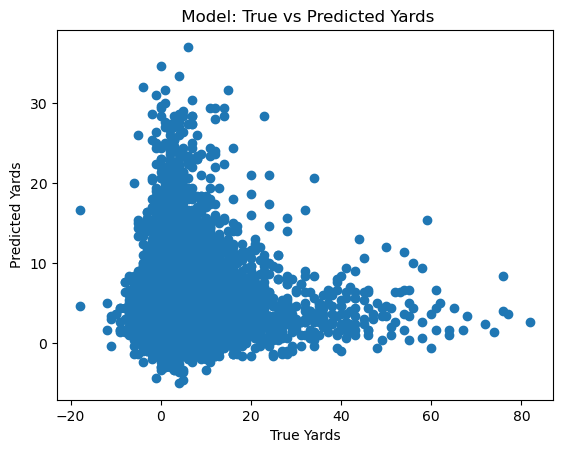

Mean Squared Error: 51.58099465163626
Mean Absolute Error: 4.614191166362261
Root Mean Squared Error: 7.1819909949565


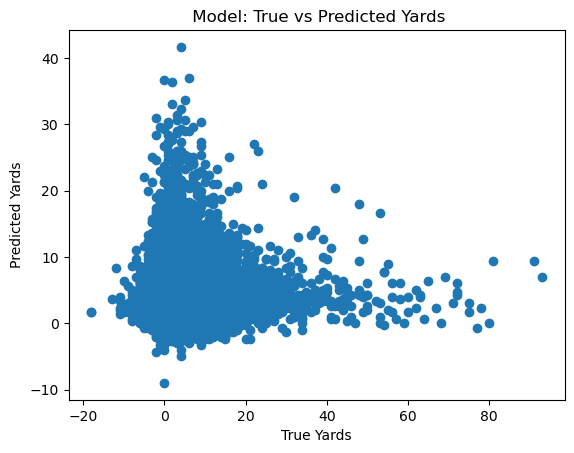

Mean Squared Error: 52.48380761601759
Mean Absolute Error: 4.597556904102594
Root Mean Squared Error: 7.244570906273028


In [6]:
# Basic model

# make pipelines
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor(n_neighbors=3))
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor(n_neighbors=3))

# test model and save predictions
run_y_test, run_predictions = test_model(run_pipeline, run_df, 0.2)
pass_y_test, pass_predictions = test_model(pass_pipeline, run_df, 0.2)

In [10]:
# estimating hyperparameters
parameters = {
    'regressor__n_neighbors': range(5,10),
    'outlier_remover__kw_args': [
        {
            'strict_columns': ['yardline_100', 'ydstogo', 'score_differential', 'td_prob', 'drive_play_count', 'drive_start_yard_line', 'spread_line', 'total_line', 'overall'],
        },
        {
            'strict_columns': [],
        }
    ]
}

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor())

run_grid_search = estimate_hyperparams(run_df, run_pipeline, 'neg_root_mean_squared_error', 'KNN_RUN', k_folds=3, parameters=parameters, data_fraction=1.0)
pass_grid_search = estimate_hyperparams(pass_df, pass_pipeline, 'neg_root_mean_squared_error', 'KNN_RUN', k_folds=3, parameters=parameters, data_fraction=1.0)

{'outlier_remover__kw_args': {'strict_columns': []},
 'regressor__n_neighbors': 9}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_outlier_remover__kw_args,param_regressor__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.208176,0.007876,11.551067,0.197131,"{'strict_columns': ['yardline_100', 'ydstogo',...",5,{'outlier_remover__kw_args': {'strict_columns'...,-6.707475,-6.914220,-6.886524,-6.836073,0.091633,10
1,0.221140,0.004835,12.140131,0.099131,"{'strict_columns': ['yardline_100', 'ydstogo',...",6,{'outlier_remover__kw_args': {'strict_columns'...,-6.609606,-6.815042,-6.788052,-6.737566,0.091150,8
2,0.230698,0.004895,12.309340,0.028877,"{'strict_columns': ['yardline_100', 'ydstogo',...",7,{'outlier_remover__kw_args': {'strict_columns'...,-6.535191,-6.742721,-6.719868,-6.665927,0.092914,6
3,0.282971,0.073917,12.297722,0.068752,"{'strict_columns': ['yardline_100', 'ydstogo',...",8,{'outlier_remover__kw_args': {'strict_columns'...,-6.482230,-6.682576,-6.665901,-6.610236,0.090769,4
4,0.231433,0.002488,12.466152,0.040984,"{'strict_columns': ['yardline_100', 'ydstogo',...",9,{'outlier_remover__kw_args': {'strict_columns'...,-6.437177,-6.637323,-6.622708,-6.565736,0.091100,2
5,0.240784,0.004435,29.378379,21.309969,{'strict_columns': []},5,{'outlier_remover__kw_args': {'strict_columns'...,-6.702993,-6.886377,-6.840885,-6.810085,0.077970,9
6,0.232690,0.004300,13.972005,0.090544,{'strict_columns': []},6,{'outlier_remover__kw_args': {'strict_columns'...,-6.607025,-6.789906,-6.747417,-6.714783,0.078146,7
7,0.309460,0.104011,14.235180,0.080179,{'strict_columns': []},7,{'outlier_remover__kw_args': {'strict_columns'...,-6.536344,-6.716320,-6.681866,-6.644843,0.077999,5
8,0.243992,0.000860,14.281929,0.276166,{'strict_columns': []},8,{'outlier_remover__kw_args': {'strict_columns'...,-6.476818,-6.664430,-6.633347,-6.591532,0.082102,3
9,0.250923,0.008362,347.656545,472.079580,{'strict_columns': []},9,{'outlier_remover__kw_args': {'strict_columns'...,-6.433306,-6.625150,-6.594710,-6.551055,0.084184,1


{'outlier_remover__kw_args': {'strict_columns': []},
 'regressor__n_neighbors': 9}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_outlier_remover__kw_args,param_regressor__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.335912,0.085041,148.781195,184.443343,"{'strict_columns': ['yardline_100', 'ydstogo',...",5,{'outlier_remover__kw_args': {'strict_columns'...,-10.757040,-10.971388,-10.892758,-10.873729,0.088536,10
1,0.273600,0.007893,18.996005,0.789320,"{'strict_columns': ['yardline_100', 'ydstogo',...",6,{'outlier_remover__kw_args': {'strict_columns'...,-10.595887,-10.820440,-10.732956,-10.716427,0.092416,8
2,0.294979,0.006132,148.474118,181.723939,"{'strict_columns': ['yardline_100', 'ydstogo',...",7,{'outlier_remover__kw_args': {'strict_columns'...,-10.473970,-10.704205,-10.609273,-10.595816,0.094473,6
3,0.298300,0.022964,19.730286,0.361336,"{'strict_columns': ['yardline_100', 'ydstogo',...",8,{'outlier_remover__kw_args': {'strict_columns'...,-10.384207,-10.615579,-10.519807,-10.506531,0.094922,4
4,0.377424,0.092968,19.634087,0.764949,"{'strict_columns': ['yardline_100', 'ydstogo',...",9,{'outlier_remover__kw_args': {'strict_columns'...,-10.315005,-10.547374,-10.451855,-10.438078,0.095363,2
5,0.293666,0.007372,23.903054,0.172475,{'strict_columns': []},5,{'outlier_remover__kw_args': {'strict_columns'...,-10.696489,-10.949921,-10.877313,-10.841241,0.106561,9
6,0.310920,0.008275,23.995793,0.151756,{'strict_columns': []},6,{'outlier_remover__kw_args': {'strict_columns'...,-10.551507,-10.803987,-10.715608,-10.690367,0.104608,7
7,0.326521,0.006573,24.389429,0.235751,{'strict_columns': []},7,{'outlier_remover__kw_args': {'strict_columns'...,-10.443505,-10.696640,-10.597537,-10.579227,0.104150,5
8,0.389225,0.106117,24.550373,0.212731,{'strict_columns': []},8,{'outlier_remover__kw_args': {'strict_columns'...,-10.361570,-10.615327,-10.508916,-10.495271,0.104044,3
9,0.305779,0.001463,24.671905,0.146762,{'strict_columns': []},9,{'outlier_remover__kw_args': {'strict_columns'...,-10.293882,-10.545715,-10.443159,-10.427585,0.103399,1


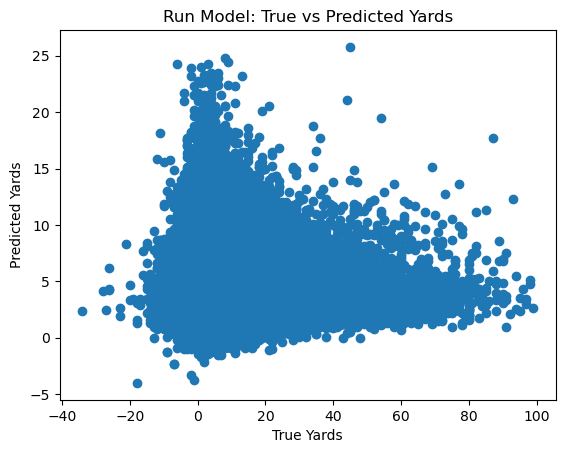

Mean Squared Error: 42.997797866801434
Mean Absolute Error: 4.097028609510492
Root Mean Squared Error: 6.5572706110699315


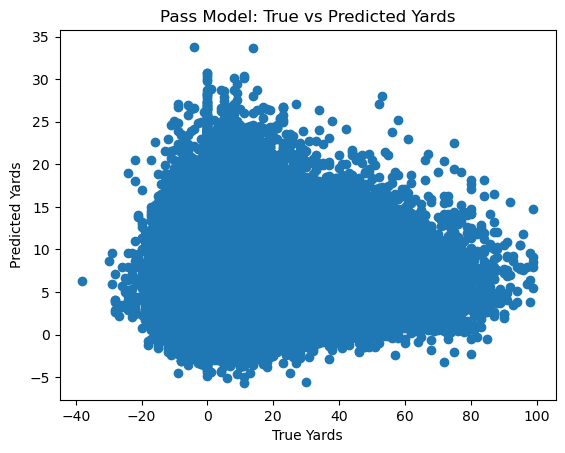

Mean Squared Error: 108.85016191079553
Mean Absolute Error: 7.448912569172973
Root Mean Squared Error: 10.43312809807277


In [36]:
# cross-validation with best hyperparameters

# make new pipeliness from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# model and save predictions
pipeline = pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pipeline, LABEL_PASS, data_fraction=1.0)

### Random Forest

2023-12-03 16:18:30.389 | INFO     | preprocessing:outlier_sampler_iqr:342 - >>> save_stats: True
2023-12-03 16:18:30.390 | INFO     | preprocessing:outlier_sampler_iqr:345 - >>> strict_columns: ['score_differential', 'drive_play_count', 'spread_line', 'total_line']


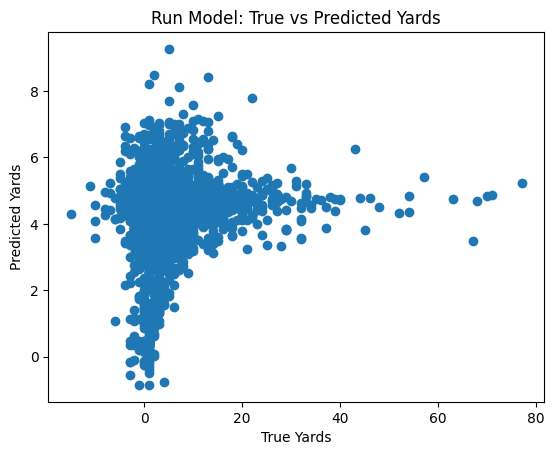

Mean Squared Error: 38.81352196075441
Mean Absolute Error: 3.8243693885584586
Root Mean Squared Error: 6.23004991639348


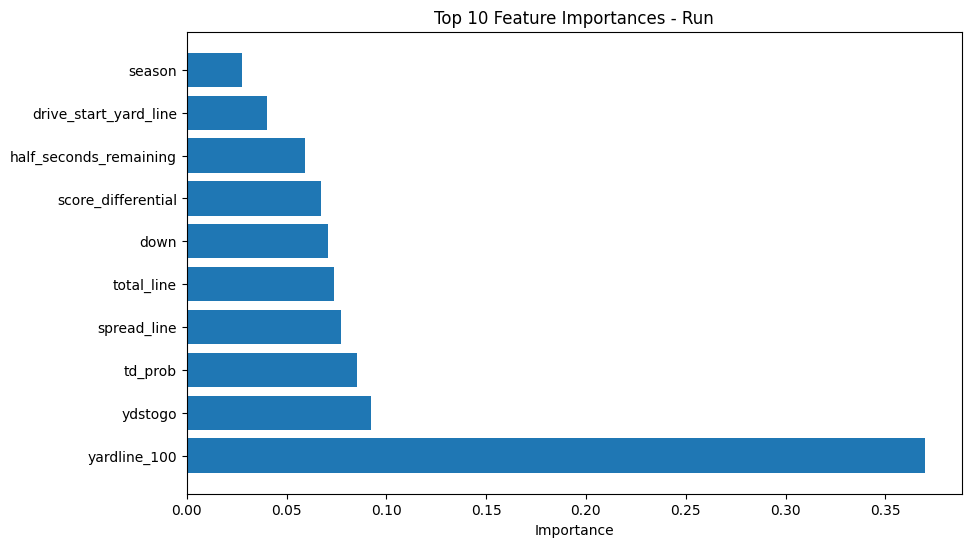

2023-12-03 16:18:36.014 | INFO     | preprocessing:outlier_sampler_iqr:342 - >>> save_stats: False
2023-12-03 16:18:36.015 | INFO     | preprocessing:outlier_sampler_iqr:345 - >>> strict_columns: ['score_differential', 'drive_play_count', 'spread_line', 'total_line']


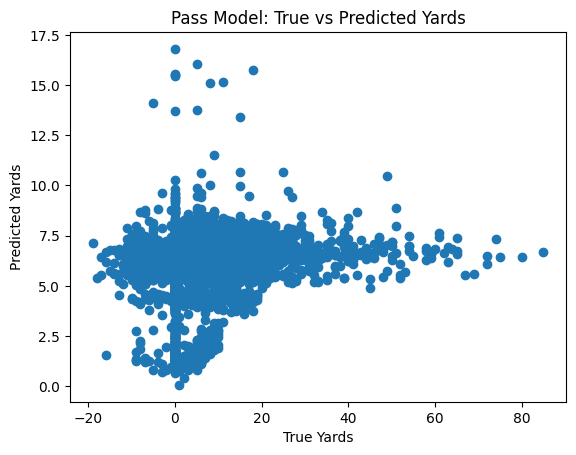

Mean Squared Error: 96.82101978915526
Mean Absolute Error: 6.963721378378812
Root Mean Squared Error: 9.839767262956745


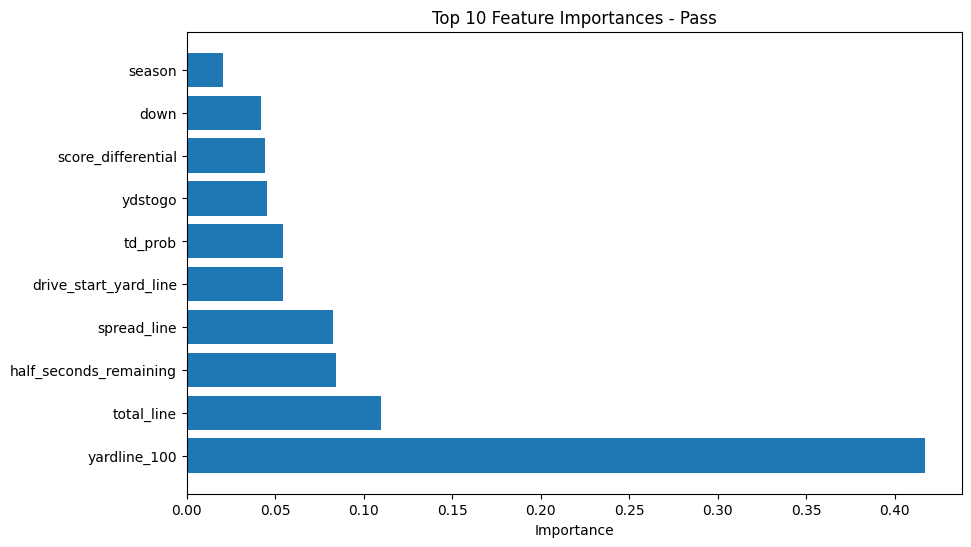

In [19]:
# Basic model
run_params = {
    'outlier_remover__kw_args': {
        'save_stats': True,
    }
}

pass_params = {
    'outlier_remover__kw_args': {
        'save_stats': False,
    }
}

# make pipelines
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5))
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5))

run_pipeline.set_params(**run_params)
pass_pipeline.set_params(**pass_params)

# test model and save predictions
run_y_test, run_predictions = test_model(run_pipeline, run_df, 0.05, label=LABEL_RUN)
plot_feature_importances(run_pipeline, LABEL_RUN)

pass_y_test, pass_predictions = test_model(pass_pipeline, pass_df, 0.05, label=LABEL_PASS)
plot_feature_importances(pass_pipeline, LABEL_PASS)

In [20]:
# estimating hyperparameters

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor())

parameters = {
    'regressor__max_depth': range(4, 6),
    'regressor__n_estimators': [20],
    'outlier_remover__kw_args': [
        {
            'save_stats': False,
        }, {
            'save_stats': True,
        }
    ]
}

run_grid_search = estimate_hyperparams(run_df, run_pipeline, 'neg_root_mean_squared_error', LABEL_RUN, k_folds=3, parameters=parameters, data_fraction=0.05)
pass_grid_search = estimate_hyperparams(pass_df, pass_pipeline, 'neg_root_mean_squared_error', LABEL_PASS, k_folds=3, parameters=parameters, data_fraction=0.05)

2023-12-03 16:18:43.197 | INFO     | preprocessing:outlier_sampler_iqr:342 - >>> save_stats: False
2023-12-03 16:18:43.197 | INFO     | preprocessing:outlier_sampler_iqr:345 - >>> strict_columns: ['score_differential', 'drive_play_count', 'spread_line', 'total_line']
2023-12-03 16:18:43.512 | INFO     | preprocessing:outlier_sampler_iqr:342 - >>> save_stats: False
2023-12-03 16:18:43.513 | INFO     | preprocessing:outlier_sampler_iqr:345 - >>> strict_columns: ['score_differential', 'drive_play_count', 'spread_line', 'total_line']
2023-12-03 16:18:43.823 | INFO     | preprocessing:outlier_sampler_iqr:342 - >>> save_stats: False
2023-12-03 16:18:43.824 | INFO     | preprocessing:outlier_sampler_iqr:345 - >>> strict_columns: ['score_differential', 'drive_play_count', 'spread_line', 'total_line']
2023-12-03 16:18:44.139 | INFO     | preprocessing:outlier_sampler_iqr:342 - >>> save_stats: False
2023-12-03 16:18:44.139 | INFO     | preprocessing:outlier_sampler_iqr:345 - >>> strict_columns: 

{'outlier_remover__kw_args': {'save_stats': False},
 'regressor__max_depth': 4,
 'regressor__n_estimators': 20}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_outlier_remover__kw_args,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.252728,0.002876,0.008334,0.000471,{'save_stats': False},4,20,{'outlier_remover__kw_args': {'save_stats': Fa...,-6.467873,-6.202224,-6.257489,-6.309195,0.114448,1
1,0.310344,0.006818,0.009171,0.000241,{'save_stats': False},5,20,{'outlier_remover__kw_args': {'save_stats': Fa...,-6.471176,-6.220806,-6.263636,-6.318539,0.109338,4
2,0.308544,0.052263,0.008121,0.000170,{'save_stats': True},4,20,{'outlier_remover__kw_args': {'save_stats': Tr...,-6.470450,-6.214405,-6.261423,-6.315426,0.111286,2
3,0.327117,0.006439,0.008651,0.000461,{'save_stats': True},5,20,{'outlier_remover__kw_args': {'save_stats': Tr...,-6.468660,-6.219600,-6.259807,-6.316022,0.109172,3


2023-12-03 16:18:48.140 | INFO     | preprocessing:outlier_sampler_iqr:342 - >>> save_stats: False
2023-12-03 16:18:48.141 | INFO     | preprocessing:outlier_sampler_iqr:345 - >>> strict_columns: ['score_differential', 'drive_play_count', 'spread_line', 'total_line']
2023-12-03 16:18:48.527 | INFO     | preprocessing:outlier_sampler_iqr:342 - >>> save_stats: False
2023-12-03 16:18:48.527 | INFO     | preprocessing:outlier_sampler_iqr:345 - >>> strict_columns: ['score_differential', 'drive_play_count', 'spread_line', 'total_line']
2023-12-03 16:18:48.906 | INFO     | preprocessing:outlier_sampler_iqr:342 - >>> save_stats: False
2023-12-03 16:18:48.906 | INFO     | preprocessing:outlier_sampler_iqr:345 - >>> strict_columns: ['score_differential', 'drive_play_count', 'spread_line', 'total_line']
2023-12-03 16:18:49.275 | INFO     | preprocessing:outlier_sampler_iqr:342 - >>> save_stats: False
2023-12-03 16:18:49.276 | INFO     | preprocessing:outlier_sampler_iqr:345 - >>> strict_columns: 

{'outlier_remover__kw_args': {'save_stats': True},
 'regressor__max_depth': 4,
 'regressor__n_estimators': 20}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_outlier_remover__kw_args,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.314295,0.005906,0.010333,0.000471,{'save_stats': False},4,20,{'outlier_remover__kw_args': {'save_stats': Fa...,-10.060059,-9.739425,-10.033861,-9.944448,0.145367,2
1,0.431185,0.068281,0.010978,0.000789,{'save_stats': False},5,20,{'outlier_remover__kw_args': {'save_stats': Fa...,-10.069538,-9.747973,-10.036076,-9.951196,0.144348,4
2,0.334184,0.006735,0.010000,0.000817,{'save_stats': True},4,20,{'outlier_remover__kw_args': {'save_stats': Tr...,-10.058960,-9.732415,-10.031529,-9.940968,0.147894,1
3,0.396393,0.003928,0.010504,0.000410,{'save_stats': True},5,20,{'outlier_remover__kw_args': {'save_stats': Tr...,-10.069000,-9.736067,-10.036404,-9.947157,0.149855,3


In [ ]:
# cross-validation with best hyperparameters

run_features, run_target = split_feature_target(run_df)
pass_features, pass_target = split_feature_target(pass_df)

# make new pipeliness from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pipeline, LABEL_PASS, data_fraction=1.0)

In [ ]:
# Plot the decision tree for passes
plot_decision_tree(run_pipeline, LABEL_PASS)

# Plot the decision tree for runs
plot_decision_tree(pass_pipeline, LABEL_RUN)

### XGBoost

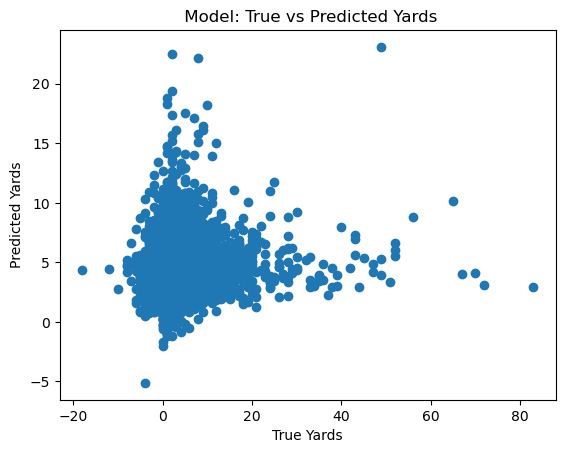

Mean Squared Error: 42.62615624199173
Mean Absolute Error: 4.122829074440102
Root Mean Squared Error: 6.528870977588064


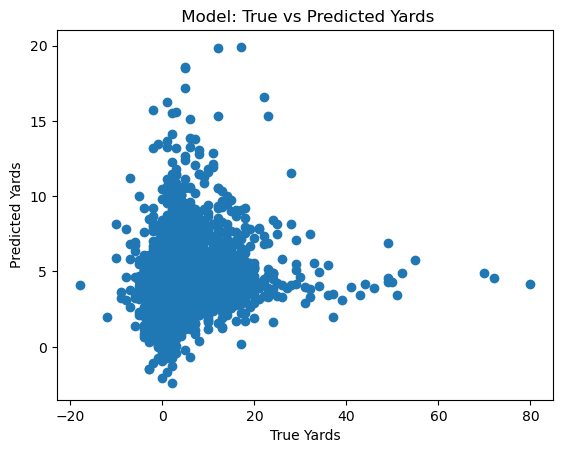

Mean Squared Error: 36.36465810102201
Mean Absolute Error: 3.9195937856041687
Root Mean Squared Error: 6.030311608948746


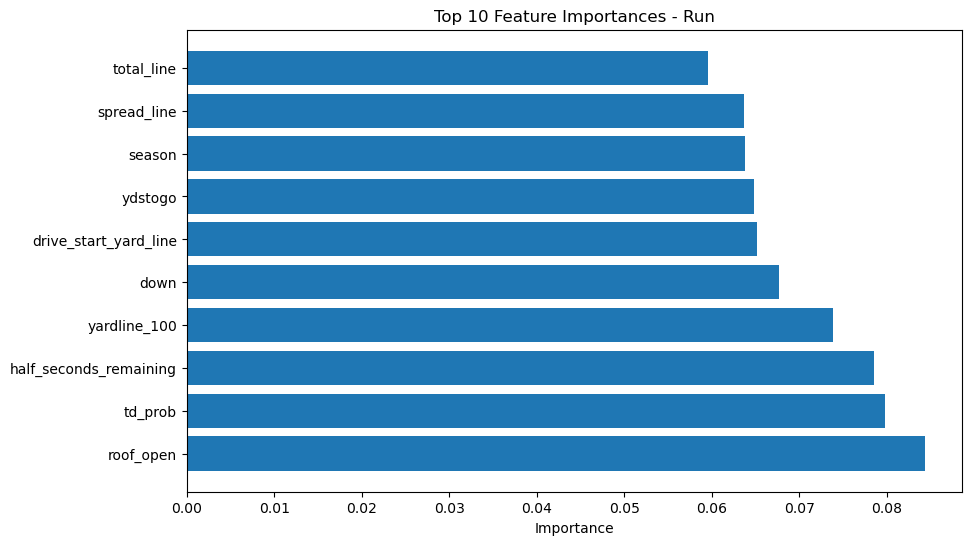

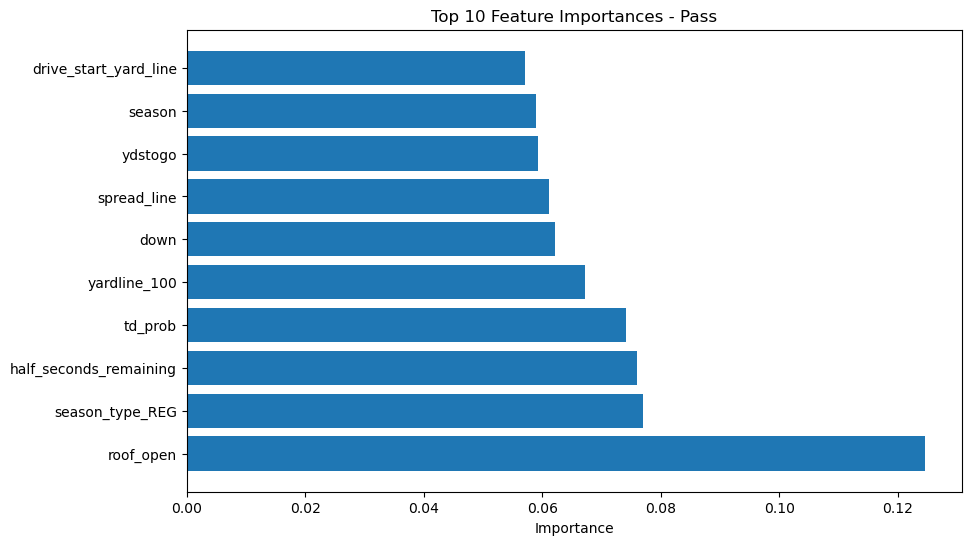

In [14]:
# Basic model

# make pipelines
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(
    xgb.XGBRegressor(
        learning_rate = 0.022,
        n_estimators  = 1000,
        max_depth     = 8,
        eval_metric='rmsle'
                           )
)
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(
    xgb.XGBRegressor(
        learning_rate = 0.015,
        n_estimators  = 1000,
        max_depth     = 8,
        eval_metric='rmsle'
        )
)

# test model and save predictions
run_y_test, run_predictions = test_model(run_pipeline, run_df, 0.05)
pass_y_test, pass_predictions = test_model(pass_pipeline, run_df, 0.05)

plot_feature_importances(run_pipeline, LABEL_RUN)
plot_feature_importances(pass_pipeline, LABEL_PASS)

In [17]:
# estimating hyperparameters

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(xgb.XGBRegressor())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(xgb.XGBRegressor())

parameters = {
    "regressor__max_depth":    [3, 4, 5],
    "regressor__n_estimators": [700, 800, 900],
    "regressor__learning_rate": [0.09, 0.01, 0.011],
    "regressor__gamma": [0, 5, 10],
    'outlier_remover__kw_args': [
        {
            'strict_columns': ['yardline_100', 'ydstogo', 'score_differential', 'td_prob', 'drive_play_count', 'drive_start_yard_line', 'spread_line', 'total_line', 'overall'],
        },
        {
            'strict_columns': [],
        }
    ]
}

run_grid_search = estimate_hyperparams(run_df, run_pipeline, 'neg_root_mean_squared_error', 'XGB_RUN', k_folds=3, parameters=parameters, data_fraction=0.05)
pass_grid_search = estimate_hyperparams(pass_df, pass_pipeline, 'neg_root_mean_squared_error', 'XGB_RUN', k_folds=3, parameters=parameters, data_fraction=0.05)

{'outlier_remover__kw_args': {'strict_columns': []},
 'regressor__gamma': 0,
 'regressor__learning_rate': 0.011,
 'regressor__max_depth': 3,
 'regressor__n_estimators': 700}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_outlier_remover__kw_args,param_regressor__gamma,param_regressor__learning_rate,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.912665,0.030307,0.010460,0.000177,"{'strict_columns': ['yardline_100', 'ydstogo',...",0,0.09,3,700,{'outlier_remover__kw_args': {'strict_columns'...,-6.185085,-6.612692,-6.448455,-6.415411,0.176127,120
1,1.085718,0.095205,0.009747,0.000415,"{'strict_columns': ['yardline_100', 'ydstogo',...",0,0.09,3,800,{'outlier_remover__kw_args': {'strict_columns'...,-6.209894,-6.637994,-6.474680,-6.440856,0.176400,126
2,1.128956,0.012333,0.010166,0.000551,"{'strict_columns': ['yardline_100', 'ydstogo',...",0,0.09,3,900,{'outlier_remover__kw_args': {'strict_columns'...,-6.241403,-6.661002,-6.497439,-6.466615,0.172682,131
3,1.247313,0.085910,0.010568,0.000371,"{'strict_columns': ['yardline_100', 'ydstogo',...",0,0.09,4,700,{'outlier_remover__kw_args': {'strict_columns'...,-6.290856,-6.661434,-6.582150,-6.511480,0.159327,140
4,1.381333,0.005089,0.012272,0.000281,"{'strict_columns': ['yardline_100', 'ydstogo',...",0,0.09,4,800,{'outlier_remover__kw_args': {'strict_columns'...,-6.320442,-6.689804,-6.611861,-6.540703,0.158965,148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,1.594338,0.120831,0.013751,0.001126,{'strict_columns': []},10,0.011,4,800,{'outlier_remover__kw_args': {'strict_columns'...,-6.012375,-6.359147,-6.304716,-6.225413,0.152271,50
158,1.688440,0.032023,0.013107,0.000854,{'strict_columns': []},10,0.011,4,900,{'outlier_remover__kw_args': {'strict_columns'...,-6.015655,-6.363148,-6.307968,-6.228924,0.152477,59
159,1.696724,0.036764,0.013853,0.000438,{'strict_columns': []},10,0.011,5,700,{'outlier_remover__kw_args': {'strict_columns'...,-6.052028,-6.382258,-6.308375,-6.247554,0.141509,82
160,1.861290,0.022306,0.014797,0.000737,{'strict_columns': []},10,0.011,5,800,{'outlier_remover__kw_args': {'strict_columns'...,-6.060753,-6.389059,-6.310911,-6.253574,0.140028,90


{'outlier_remover__kw_args': {'strict_columns': []},
 'regressor__gamma': 0,
 'regressor__learning_rate': 0.01,
 'regressor__max_depth': 3,
 'regressor__n_estimators': 700}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_outlier_remover__kw_args,param_regressor__gamma,param_regressor__learning_rate,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.043834,0.039058,0.012093,0.000722,"{'strict_columns': ['yardline_100', 'ydstogo',...",0,0.09,3,700,{'outlier_remover__kw_args': {'strict_columns'...,-10.923145,-10.286430,-10.384337,-10.531304,0.279942,124
1,1.284871,0.086734,0.014150,0.000787,"{'strict_columns': ['yardline_100', 'ydstogo',...",0,0.09,3,800,{'outlier_remover__kw_args': {'strict_columns'...,-10.956157,-10.326383,-10.424305,-10.568948,0.276701,130
2,80.324635,111.710264,0.014216,0.000573,"{'strict_columns': ['yardline_100', 'ydstogo',...",0,0.09,3,900,{'outlier_remover__kw_args': {'strict_columns'...,-10.988853,-10.361429,-10.466582,-10.605621,0.274365,136
3,1.443923,0.114335,0.015186,0.001834,"{'strict_columns': ['yardline_100', 'ydstogo',...",0,0.09,4,700,{'outlier_remover__kw_args': {'strict_columns'...,-10.990635,-10.502616,-10.563897,-10.685716,0.217057,146
4,11.233401,13.567304,0.014265,0.000432,"{'strict_columns': ['yardline_100', 'ydstogo',...",0,0.09,4,800,{'outlier_remover__kw_args': {'strict_columns'...,-11.024002,-10.550871,-10.612604,-10.729159,0.210003,149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,1.926460,0.003453,0.015705,0.001049,{'strict_columns': []},10,0.011,4,800,{'outlier_remover__kw_args': {'strict_columns'...,-10.450123,-10.067202,-9.989168,-10.168831,0.201439,28
158,2.157677,0.016151,0.018895,0.002480,{'strict_columns': []},10,0.011,4,900,{'outlier_remover__kw_args': {'strict_columns'...,-10.454630,-10.070924,-10.002598,-10.176051,0.198950,35
159,2.230199,0.108320,0.016992,0.000698,{'strict_columns': []},10,0.011,5,700,{'outlier_remover__kw_args': {'strict_columns'...,-10.483328,-10.072979,-10.000965,-10.185757,0.212458,45
160,2.440402,0.034055,0.018639,0.000080,{'strict_columns': []},10,0.011,5,800,{'outlier_remover__kw_args': {'strict_columns'...,-10.496753,-10.079644,-10.016937,-10.197778,0.212951,56


In [19]:
# estimating hyperparameters

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(xgb.XGBRegressor())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(xgb.XGBRegressor())

parameters = {
    "regressor__max_depth":    [3, 6, 9],
    "regressor__n_estimators": [600, 800, 1000],
    "regressor__learning_rate": [0.09, 0.01, 0.011],
    "regressor__gamma": [0, 5, 10]
}

run_grid_search = estimate_hyperparams(run_df, run_pipeline, 'neg_root_mean_squared_error', 'XGB_RUN', k_folds=3, parameters=parameters, data_fraction=0.25)
pass_grid_search = estimate_hyperparams(pass_df, pass_pipeline, 'neg_root_mean_squared_error', 'XGB_RUN', k_folds=3, parameters=parameters, data_fraction=0.25)

{'regressor__gamma': 10,
 'regressor__learning_rate': 0.01,
 'regressor__max_depth': 3,
 'regressor__n_estimators': 1000}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__gamma,param_regressor__learning_rate,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,3.560671,0.060975,0.033231,0.001923,0,0.09,3,600,"{'regressor__gamma': 0, 'regressor__learning_r...",-6.370411,-6.286070,-6.056554,-6.237678,0.132622,41
1,4.727494,0.020958,0.036904,0.001434,0,0.09,3,800,"{'regressor__gamma': 0, 'regressor__learning_r...",-6.383886,-6.299658,-6.070113,-6.251219,0.132597,51
2,5.931366,0.038445,0.042042,0.001982,0,0.09,3,1000,"{'regressor__gamma': 0, 'regressor__learning_r...",-6.400182,-6.313389,-6.083985,-6.265852,0.133392,60
3,7.586479,0.085308,0.055471,0.000299,0,0.09,6,600,"{'regressor__gamma': 0, 'regressor__learning_r...",-6.492913,-6.406290,-6.187200,-6.362134,0.128653,66
4,10.285012,0.197074,0.067123,0.001339,0,0.09,6,800,"{'regressor__gamma': 0, 'regressor__learning_r...",-6.525755,-6.446435,-6.230421,-6.400870,0.124800,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,12.051927,0.547817,0.085685,0.006039,10,0.011,6,800,"{'regressor__gamma': 10, 'regressor__learning_...",-6.352209,-6.262861,-6.037508,-6.217526,0.132415,28
77,15.464734,0.603638,0.097168,0.002295,10,0.011,6,1000,"{'regressor__gamma': 10, 'regressor__learning_...",-6.360991,-6.270635,-6.044799,-6.225475,0.132976,34
78,15.450916,0.467357,0.110727,0.005756,10,0.011,9,600,"{'regressor__gamma': 10, 'regressor__learning_...",-6.368238,-6.282711,-6.066107,-6.239019,0.127155,43
79,18.770313,1.121181,0.136076,0.002675,10,0.011,9,800,"{'regressor__gamma': 10, 'regressor__learning_...",-6.386032,-6.302903,-6.081717,-6.256884,0.128427,53


{'regressor__gamma': 10,
 'regressor__learning_rate': 0.01,
 'regressor__max_depth': 3,
 'regressor__n_estimators': 600}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__gamma,param_regressor__learning_rate,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,4.982836,0.006153,0.049534,0.000462,0,0.09,3,600,"{'regressor__gamma': 0, 'regressor__learning_r...",-9.970191,-9.752671,-10.053548,-9.925470,0.126838,38
1,6.338336,0.035913,0.057521,0.002485,0,0.09,3,800,"{'regressor__gamma': 0, 'regressor__learning_r...",-9.983452,-9.767416,-10.067640,-9.939503,0.126445,41
2,8.080081,0.143285,0.064550,0.000928,0,0.09,3,1000,"{'regressor__gamma': 0, 'regressor__learning_r...",-9.996295,-9.780310,-10.079805,-9.952137,0.126192,48
3,173.584057,230.832494,0.077294,0.006433,0,0.09,6,600,"{'regressor__gamma': 0, 'regressor__learning_r...",-10.115666,-9.910565,-10.196156,-10.074129,0.120234,64
4,12.837825,0.141111,0.088461,0.002278,0,0.09,6,800,"{'regressor__gamma': 0, 'regressor__learning_r...",-10.163799,-9.959600,-10.243211,-10.122204,0.119461,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,14.646378,1.218646,0.084089,0.002358,10,0.011,6,800,"{'regressor__gamma': 10, 'regressor__learning_...",-9.959007,-9.748082,-10.037609,-9.914899,0.122244,30
77,15.880072,0.228583,0.106151,0.003502,10,0.011,6,1000,"{'regressor__gamma': 10, 'regressor__learning_...",-9.967374,-9.754615,-10.044832,-9.922274,0.122697,36
78,16.896550,0.233894,0.115623,0.001798,10,0.011,9,600,"{'regressor__gamma': 10, 'regressor__learning_...",-9.987740,-9.792966,-10.080383,-9.953696,0.119781,51
79,22.214374,0.260016,0.151973,0.004855,10,0.011,9,800,"{'regressor__gamma': 10, 'regressor__learning_...",-10.003030,-9.814310,-10.101218,-9.972853,0.119058,57


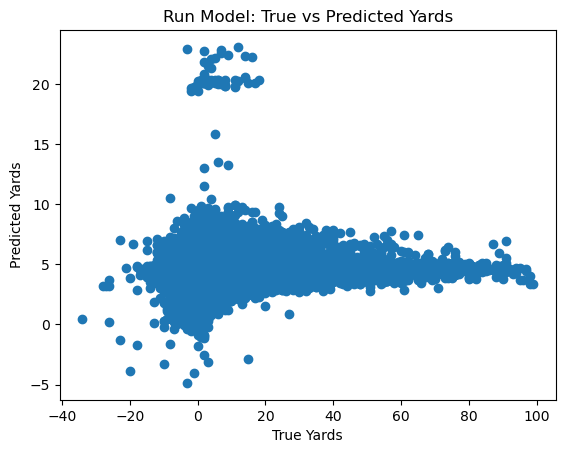

Mean Squared Error: 38.4010008526389
Mean Absolute Error: 3.7498007172983545
Root Mean Squared Error: 6.196854109355722


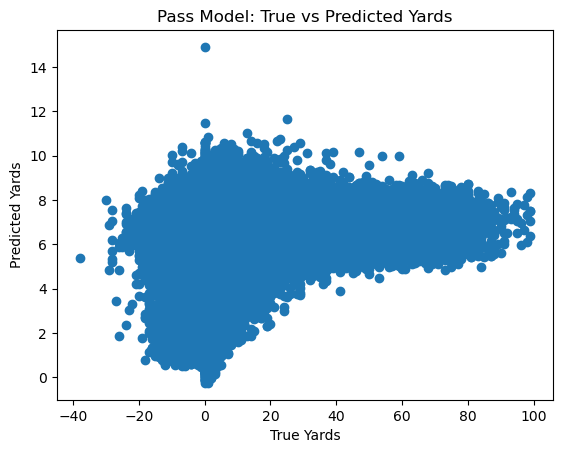

Mean Squared Error: 97.23972175789919
Mean Absolute Error: 7.006348759399173
Root Mean Squared Error: 9.861020320326856


In [25]:
pipeline = PREPROCESSOR.make_preprocessing_pipeline(xgb.XGBRegressor())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions
run_pipeline = pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions
pass_pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pipeline, LABEL_PASS, data_fraction=1.0)

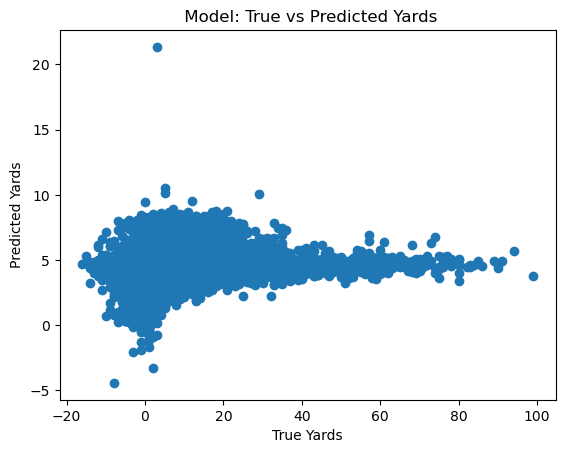

Mean Squared Error: 37.59061649536803
Mean Absolute Error: 3.7314071349826263
Root Mean Squared Error: 6.131118698522157


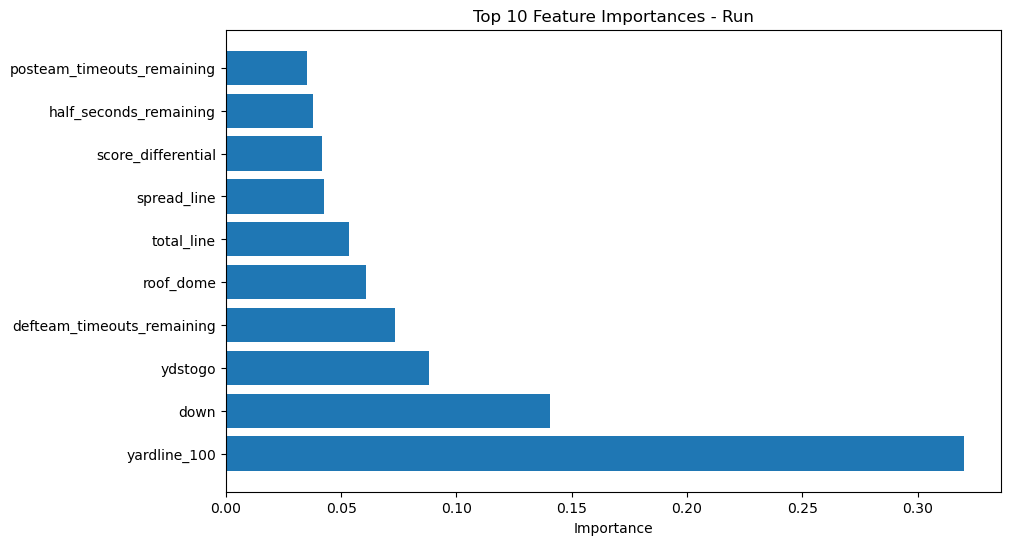

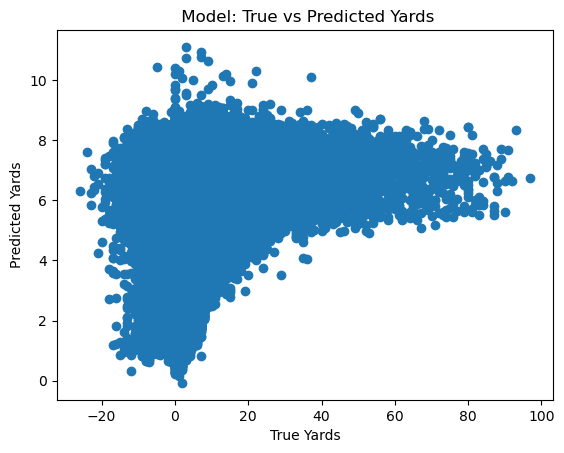

Mean Squared Error: 95.9511069207346
Mean Absolute Error: 6.971533309059807
Root Mean Squared Error: 9.795463588862683


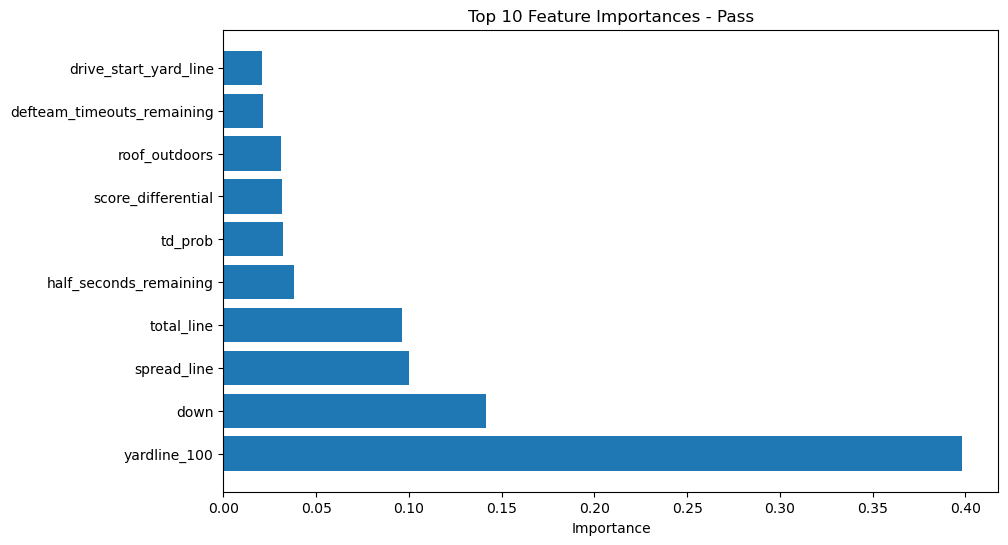

In [38]:
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(xgb.XGBRegressor())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(xgb.XGBRegressor())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions
run_pipeline = run_pipeline.set_params(**run_params)
run_predictions = test_model(run_pipeline, run_df, 1.0)
plot_feature_importances(run_pipeline, LABEL_RUN)

# set params, test model and save predictions
pass_pipeline = pass_pipeline.set_params(**pass_params)
pass_predictions = test_model(pass_pipeline, pass_df, 1.0)
plot_feature_importances(pass_pipeline, LABEL_PASS)

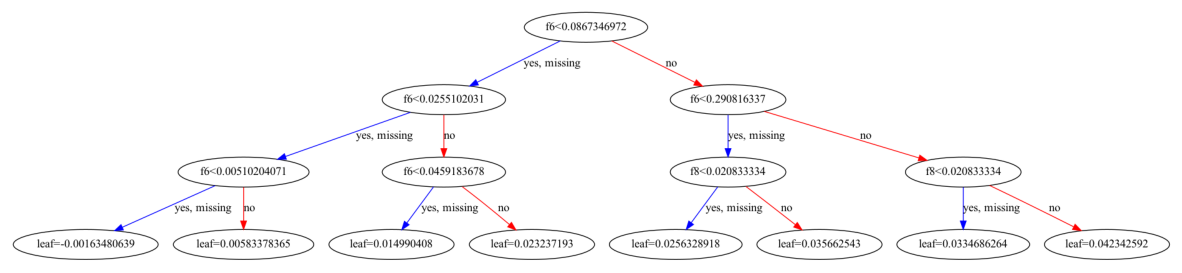

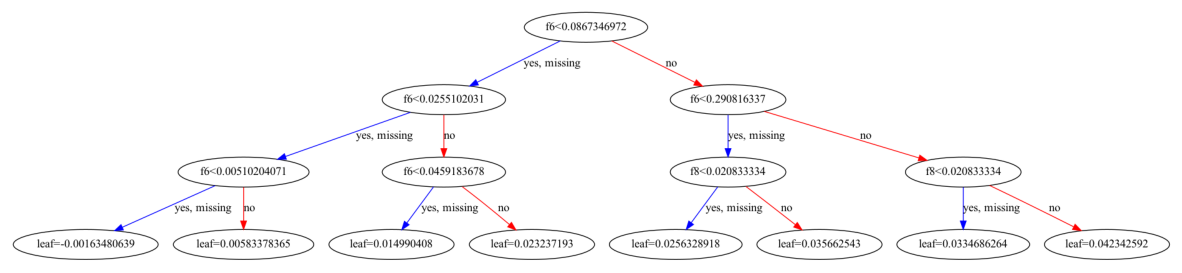

In [34]:
# Plot the decision tree for passes
plot_decision_tree_xgb(run_pipeline, LABEL_PASS)

# Plot the decision tree for runs
plot_decision_tree_xgb(pass_pipeline, LABEL_RUN)

### Artificial Neuronal Network

In [ ]:
# Basic model

run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(
    MLPWithHistory(
        mlp_params={'hidden_layer_sizes': (50,),
  'activation': 'relu',
  'solver': 'adam',
  'max_iter': 100}
    )
)
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(
    MLPWithHistory(
        mlp_params={'hidden_layer_sizes': (50,),
  'activation': 'relu',
  'solver': 'adam',
  'max_iter': 100}
    )
)

# estimate run model
run_y_test, run_predictions = test_model(run_pipeline, run_df, 0.2)
run_mlp = run_pipeline.named_steps['regressor']
plot_train_val_loss(run_mlp.training_losses, run_mlp.validation_losses, LABEL_RUN)

# estimate pass model
pass_y_test, pass_predictions = test_model(pass_pipeline, pass_df, 0.2)
pass_mlp = pass_pipeline.named_steps['regressor']
plot_train_val_loss(pass_mlp.training_losses, pass_mlp.validation_losses, LABEL_PASS)

In [ ]:
# estimating hyperparameters

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(MLPWithHistory())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(MLPWithHistory())

parameters = {
    'regressor__mlp_params': generate_param_combinations({
        'hidden_layer_sizes': [(10,), (50,), (10,5), (20,10)], 
        'activation': ['relu'], 
        'solver': ['adam'], 
        'max_iter': [100] 
    })
}

run_grid_search = estimate_hyperparams(run_df, run_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)
pass_grid_search = estimate_hyperparams(pass_df, pass_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)

In [ ]:
pipeline = PREPROCESSOR.make_preprocessing_pipeline(MLPWithHistory())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pipeline, LABEL_PASS, data_fraction=1.0)